## pip Installation

In [1]:
pip install matplotlib seaborn scikit-learn 

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached scipy-1.15.3-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/8.1 MB 8.4 MB/s eta 0:00:01
   -------------- ------------------------- 2.9/8.1 MB 8.0 MB/s eta 0:00:01
   ----------------------------- ---------- 6.0/8.1 MB 10.9 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 10.9 MB/s  0:00:00
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ----------------------------------------

In [2]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

if gpus:
    print("✅ SUCCESS! TensorFlow is now using the GPU.")
    print("\nTraining speed is fixed!")
else:
    print("❌ ERROR: GPU is still not detected.")

TensorFlow Version: 2.10.0
Num GPUs Available:  1
✅ SUCCESS! TensorFlow is now using the GPU.

Training speed is fixed!


## VGG16 Transfer Learning for Image Classification (UPDATED FOR 95-98% ACCURACY)

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.10.0


## Configuration and Hyperparameters (Updated)

In [ ]:

BASE_DIR = r"F:\Program Files\CSE445_Project\CSE445_Project_VGG16\processed_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VALIDATION_DIR = os.path.join(BASE_DIR, "validation")
TEST_DIR = os.path.join(BASE_DIR, "test")


VGG16_IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = VGG16_IMAGE_SIZE + (3,)
BATCH_SIZE = 32

# --- ACCURACY IMPROVEMENT UPDATES (Two-Phase Training) ---
INITIAL_EPOCHS = 15       
EPOCHS_FINE_TUNE = 50     
LEARNING_RATE_HEAD = 1e-5
LEARNING_RATE_FINE_TUNE = 1e-6 
DROPOUT_RATE = 0.50       
EARLY_STOPPING_PATIENCE = 10 


CHECKPOINT_PATH_HEAD = "best_vgg16_head_checkpoint.h5"
CHECKPOINT_PATH_FT = "best_vgg16_fine_tuned_checkpoint.h5"


if not os.path.exists(TRAIN_DIR):
    print("ERROR: Train directory not found. Check BASE_DIR path.")
else:
    print("Setup and Configuration Complete.")

Setup and Configuration Complete.


## Data Generators

In [ ]:

train_datagen = ImageDataGenerator(
    preprocessing_function=vgg16_preprocess_input,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_test_datagen = ImageDataGenerator(preprocessing_function=vgg16_preprocess_input)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=VGG16_IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=VGG16_IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=VGG16_IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

class_labels = list(train_generator.class_indices.keys())
print(f"Class Labels: {class_labels}")

Found 32159 images belonging to 7 classes.
Found 2492 images belonging to 7 classes.
Found 1285 images belonging to 7 classes.
Class Labels: ['actinic_keratoses', 'basal_cell_carcinoma', 'benign_keratosis-like_lesions', 'dermatofibroma', 'melanocytic_Nevi', 'melanoma', 'vascular_lesions']


## Build and Compile VGG16 Model (Phase 1 Setup)

In [ ]:

base_model = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=IMAGE_SHAPE
)


base_model.trainable = False 
print("VGG16 Convolutional Base Loaded and Frozen for Phase 1.")


model = Sequential([
    base_model, 
    Flatten(), 
    Dense(512, activation='relu'),
    Dropout(DROPOUT_RATE), 
    Dense(len(class_labels), activation='softmax') 
])


model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_HEAD), # Use HEAD LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

VGG16 Convolutional Base Loaded and Frozen for Phase 1.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 27,563,847
Trainable params: 12,849,159
Non-trainable params: 14,714,688
_____________________________________________

## Phase 1: Training (Head Only)

In [ ]:

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=EARLY_STOPPING_PATIENCE, 
    restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH_HEAD, 
    monitor='val_loss', 
    save_best_only=True, 
    save_weights_only=False, 
    mode='min'
)

print(f"\nStarting Training (Phase 1: Head Only) for max {INITIAL_EPOCHS} epochs...")

history_head = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=INITIAL_EPOCHS, # Uses 15
    callbacks=[early_stopping, model_checkpoint]
)

print(f"\n✅ Phase 1 Complete. Best head-only model saved to: {CHECKPOINT_PATH_HEAD}")


Starting Training (Phase 1: Head Only) for max 15 epochs...
Epoch 1/15
1004/1004 [==============================] - 788s 774ms/step - loss: 3.1965 - accuracy: 0.3881 - val_loss: 1.8699 - val_accuracy: 0.4022
Epoch 2/15
1004/1004 [==============================] - 224s 223ms/step - loss: 1.4776 - accuracy: 0.4863 - val_loss: 1.5695 - val_accuracy: 0.4602
Epoch 3/15
1004/1004 [==============================] - 220s 219ms/step - loss: 1.2524 - accuracy: 0.5439 - val_loss: 1.4234 - val_accuracy: 0.5057
Epoch 4/15
1004/1004 [==============================] - 229s 228ms/step - loss: 1.1296 - accuracy: 0.5834 - val_loss: 1.2694 - val_accuracy: 0.5394
Epoch 5/15
1004/1004 [==============================] - 223s 222ms/step - loss: 1.0287 - accuracy: 0.6151 - val_loss: 1.2925 - val_accuracy: 0.5223
Epoch 6/15
1004/1004 [==============================] - 223s 222ms/step - loss: 0.9554 - accuracy: 0.6403 - val_loss: 1.3609 - val_accuracy: 0.5150
Epoch 7/15
1004/1004 [=============================

## Phase 2: Fine-Tuning VGG16 (Critical for 95%+ Accuracy)

In [ ]:

try:
    model.load_weights(CHECKPOINT_PATH_HEAD)
    print(f"Loaded best head-only weights from {CHECKPOINT_PATH_HEAD}")
except Exception as e:
    print(f"Error loading initial weights: {e}. Proceeding with current weights.")
    

base_model.trainable = True


trainable_count = 0
for layer in base_model.layers:
 
    if layer.name.startswith('block1') or layer.name.startswith('block2') or layer.name.startswith('block3'):
        layer.trainable = False
   
    else:
        layer.trainable = True
        trainable_count += 1

print(f"Total trainable layers in VGG16 base (Block 4 & 5): {trainable_count}")
print("VGG16 Base Model partially unfrozen for fine-tuning.")



model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_FINE_TUNE), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


early_stopping_ft = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=EARLY_STOPPING_PATIENCE, 
    restore_best_weights=True
)

model_checkpoint_ft = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH_FT, 
    monitor='val_loss', 
    save_best_only=True, 
    save_weights_only=False, 
    mode='min'
)


print(f"\nStarting Fine-Tuning (Phase 2) for max {EPOCHS_FINE_TUNE} epochs...")

history_ft = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_FINE_TUNE, 
    callbacks=[early_stopping_ft, model_checkpoint_ft]
)

print(f"\n✅ Phase 2 Complete. Best fine-tuned model saved to: {CHECKPOINT_PATH_FT}")

Loaded best head-only weights from best_vgg16_head_checkpoint.h5
Total trainable layers in VGG16 base (Block 4 & 5): 9
VGG16 Base Model partially unfrozen for fine-tuning.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 27

## Training History Plot

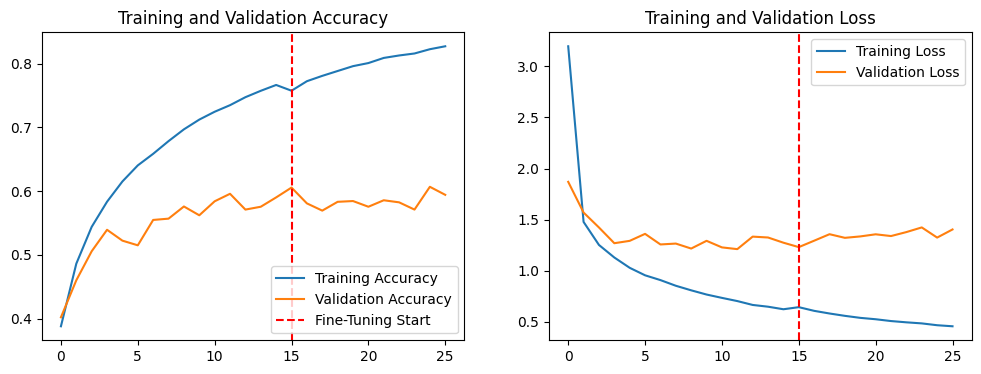

In [ ]:
def plot_training_history(history, history_ft=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    if history_ft:
        acc += history_ft.history['accuracy']
        val_acc += history_ft.history['val_accuracy']
        loss += history_ft.history['loss']
        val_loss += history_ft.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    
    plt.axvline(x=len(history.epoch), color='r', linestyle='--', label='Fine-Tuning Start')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.axvline(x=len(history.epoch), color='r', linestyle='--')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


if 'history_head' in locals() and 'history_ft' in locals():
    plot_training_history(history_head, history_ft)
else:
    print("Run the training cells first to generate history objects.")

## Final Model Evaluation

In [ ]:
print("\n--- Final Evaluation ---")
try:
    
    final_model = load_model(CHECKPOINT_PATH_FT)
    print(f"Loaded best fine-tuned model: {CHECKPOINT_PATH_FT}")
except Exception as e:
    print(f"Error loading fine-tuned model: {e}. Loading head-only model.")
    final_model = load_model(CHECKPOINT_PATH_HEAD)


test_generator.reset()

loss, accuracy = final_model.evaluate(
    test_generator,
    steps=test_generator.samples // BATCH_SIZE
)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")



--- Final Evaluation ---
Loaded best fine-tuned model: best_vgg16_fine_tuned_checkpoint.h5
40/40 [==============================] - 13s 336ms/step - loss: 1.2564 - accuracy: 0.6086

Test Loss: 1.2564
Test Accuracy: 60.86%
Target Accuracy: 95-98%


## Visualize ROC Curve

In [ ]:

plt.figure(figsize=(10, 8))


num_classes = len(class_labels)
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        label=f'{class_labels[i]} (AUC = {roc_auc:.2f})'
    )

plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

NameError: name 'roc_curve' is not defined

<Figure size 1000x800 with 0 Axes>

## Classification Report and Confusion Matrix


--- Classification Report and Confusion Matrix ---
41/41 [==============================] - 4s 86ms/step

Classification Report
                               precision    recall  f1-score   support

            actinic_keratoses       0.14      0.60      0.23        42
         basal_cell_carcinoma       0.78      0.10      0.18        67
benign_keratosis-like_lesions       0.28      0.22      0.25       142
               dermatofibroma       0.15      0.29      0.20        14
             melanocytic_Nevi       0.87      0.73      0.79       858
                     melanoma       0.33      0.51      0.40       144
             vascular_lesions       0.64      0.78      0.70        18

                     accuracy                           0.61      1285
                    macro avg       0.46      0.46      0.39      1285
                 weighted avg       0.70      0.61      0.63      1285



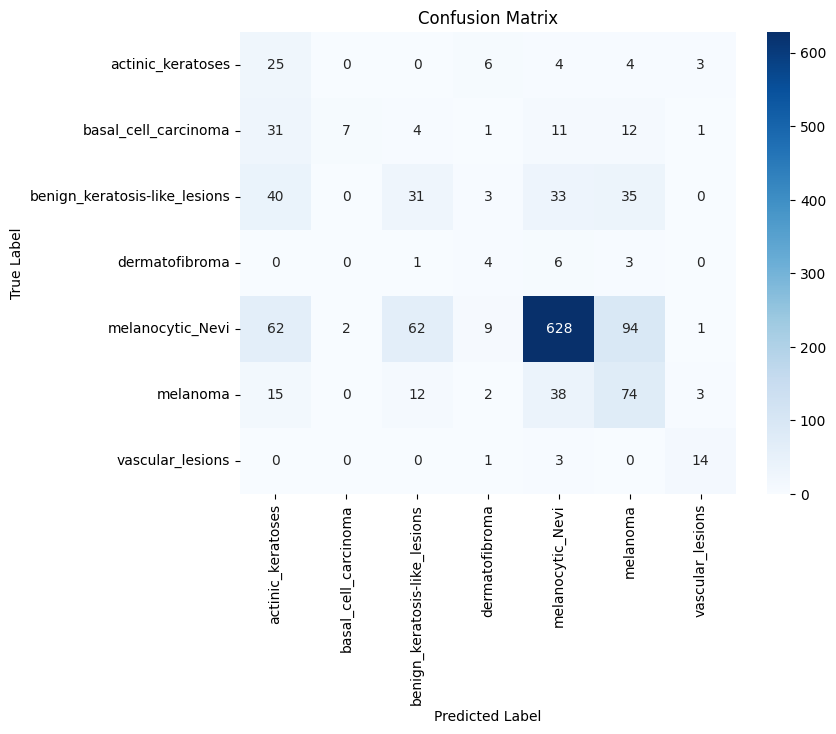

In [14]:
print("\n--- Classification Report and Confusion Matrix ---")

test_generator.reset() # Important to ensure we start from the beginning
Y_pred = final_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

print('\nClassification Report')
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Visualize 10 Random Test Predictions 


--- Visualizing 10 Random Test Predictions ---
Found 1285 images belonging to 7 classes.
1/1 [==============================] - 2s 2s/step


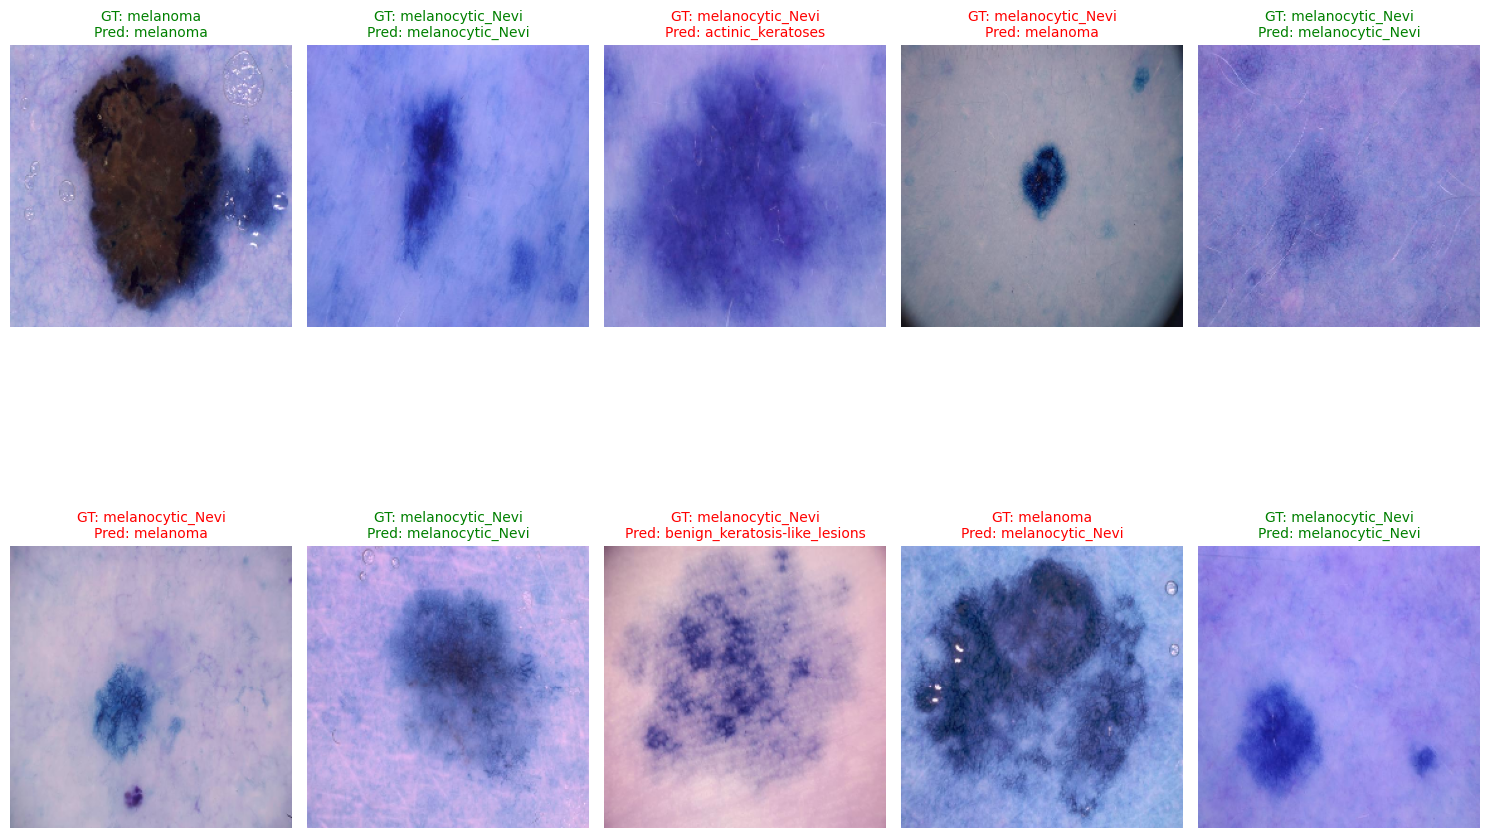

In [ ]:
print("\n--- Visualizing 10 Random Test Predictions ---")


full_test_datagen = ImageDataGenerator(preprocessing_function=vgg16_preprocess_input)
full_test_generator = full_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=VGG16_IMAGE_SIZE,
    batch_size=test_generator.n, 
    class_mode='categorical',
    shuffle=False 
)


images_full, labels_full_one_hot = full_test_generator.next()
labels_full = np.argmax(labels_full_one_hot, axis=1) 



num_samples = 10
all_indices = np.arange(images_full.shape[0])
sample_indices = np.random.choice(all_indices, size=num_samples, replace=False)


images_batch = images_full[sample_indices] 
labels_batch = labels_full[sample_indices] 



sample_preds_probs = final_model.predict(images_batch)
sample_preds = np.argmax(sample_preds_probs, axis=1)



plt.figure(figsize=(15, 12))
for i in range(num_samples):
    ax = plt.subplot(2, 5, i + 1)
    
    
    img_display = images_batch[i].copy()
    img_display[..., 0] += 103.939 
    img_display[..., 1] += 116.779 
    img_display[..., 2] += 123.68  
    img_display = np.clip(img_display, 0, 255).astype('uint8')
    
    plt.imshow(img_display)
    
    true_label = class_labels[labels_batch[i]]
    pred_label = class_labels[sample_preds[i]]
    
    # Determine color based on prediction accuracy
    color = "green" if true_label == pred_label else "red"
    
    title = f"GT: {true_label}\nPred: {pred_label}"
    plt.title(title, color=color, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()